In [1]:
import os
import random
import string

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from PIL import Image
import cv2 as cv

In [2]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

<br>

In [3]:
# Wafer file to crop
file = "../augmented_dataset/artificial_images/artificial_wafer_1.tif"
wafer = Image.open(file)
seg_tissues = pd.read_csv(f"../augmented_dataset/artificial_images/seg_tissues_artif_1.txt", sep="\t|,", header=None, names=index, engine='python')
seg_mag = pd.read_csv(f"../augmented_dataset/artificial_images/seg_mag_artif_1.txt", sep="\t|,", header=None, names=index, engine='python')

# Height and width of the resulting section in pixels
section_size = 600

# Number of sections that will be generated
number_of_sections = 20

<br>

In [4]:
wafer.size

(4160, 3110)

In [5]:
''.join(random.choices(string.ascii_lowercase + string.digits, k=20))

'noyrrq19qg5b7x88b1fg'

In [6]:
def generate_mask(image, points):
    # size of the image
    height = image.size[0]
    width = image.size[1]
    
    # init mask
    img_mask = np.zeros([height,width],dtype=np.uint8)
    img_mask.fill(0)
    
    cv.fillConvexPoly(img_mask, points, 255)
    
    return img_mask

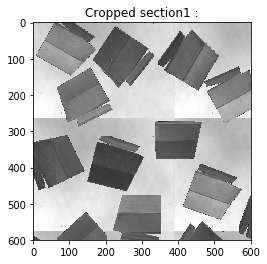

[162, 230, 170, 112, 273, 52, 255]


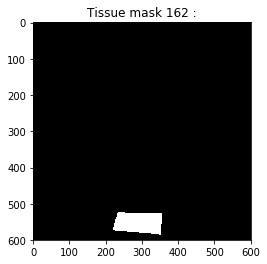

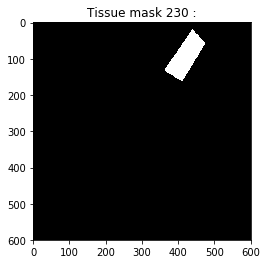

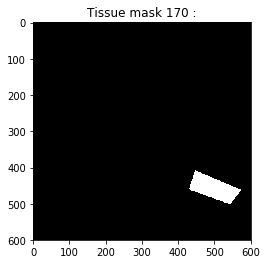

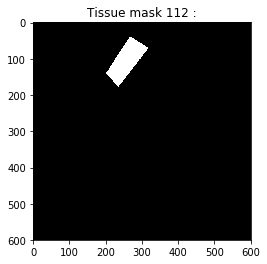

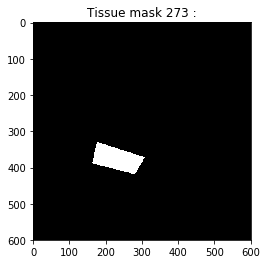

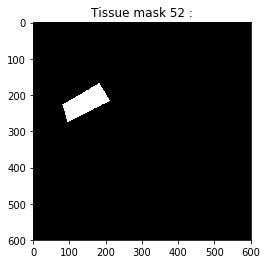

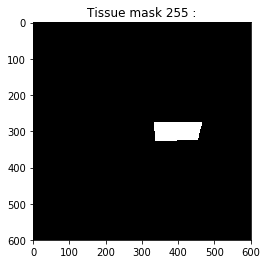

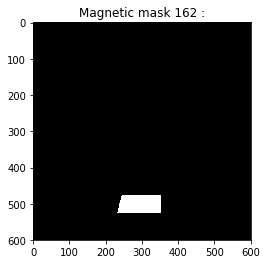

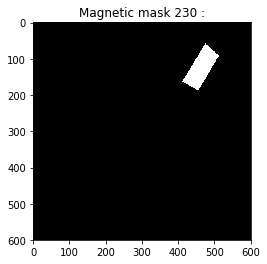

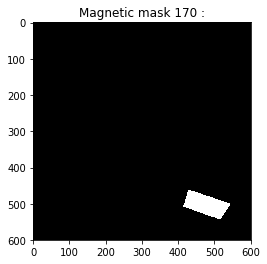

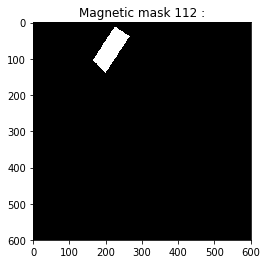

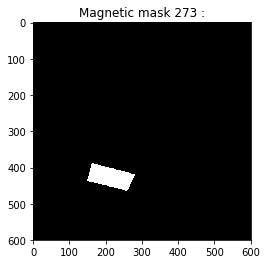

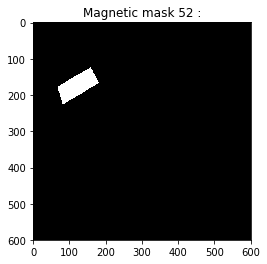

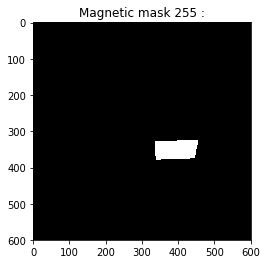

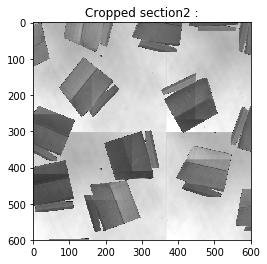

[96, 193, 72, 47, 176]


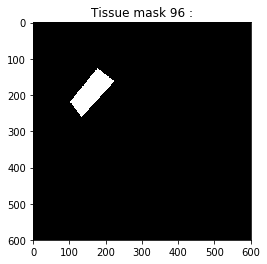

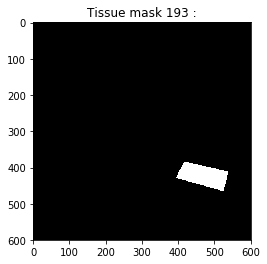

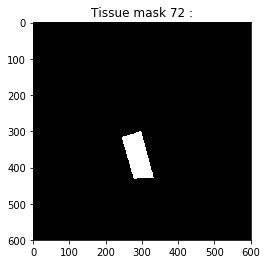

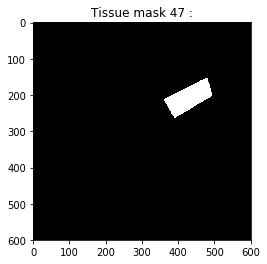

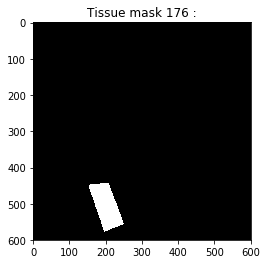

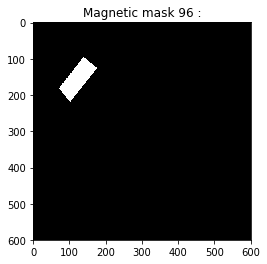

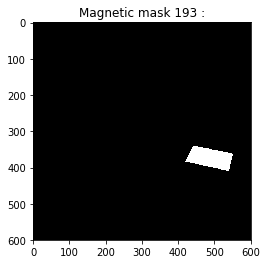

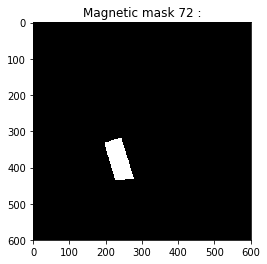

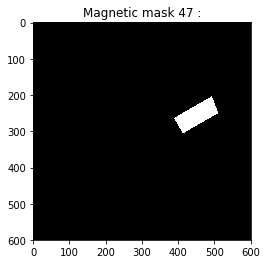

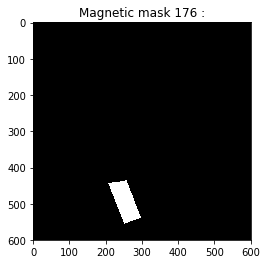

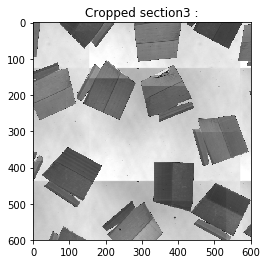

[264, 12, 272, 122, 94, 223]


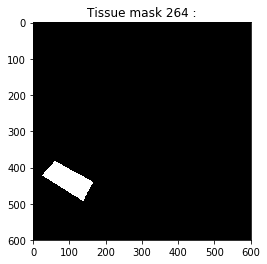

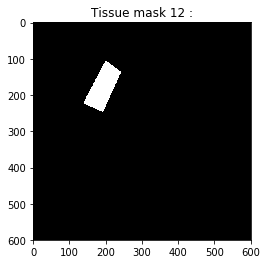

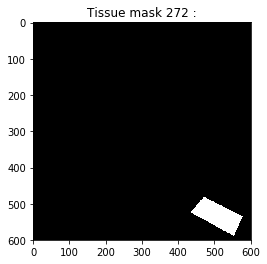

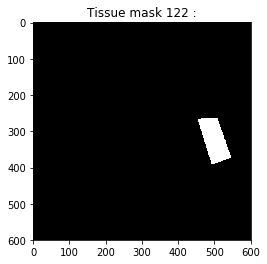

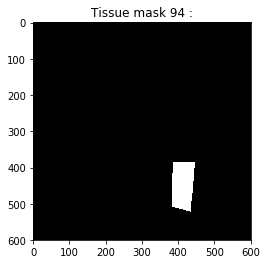

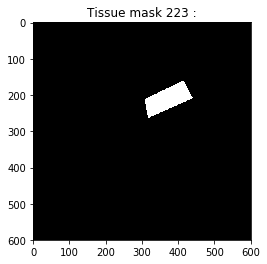

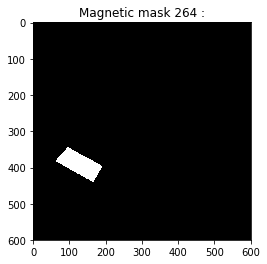

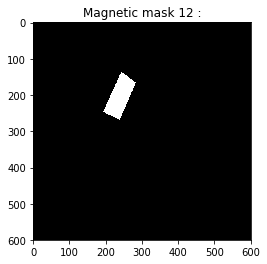

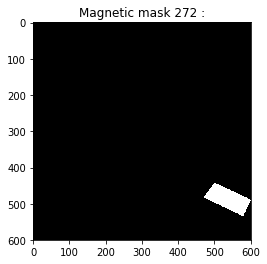

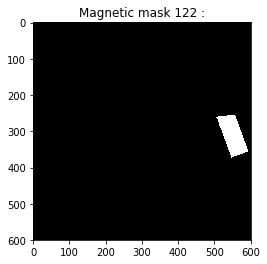

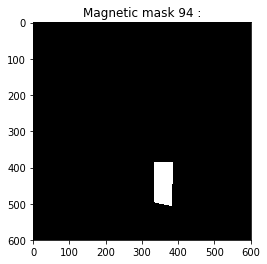

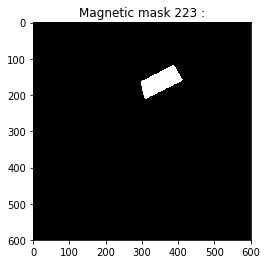

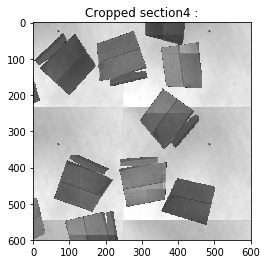

[233, 174, 215, 24, 88, 61, 216]


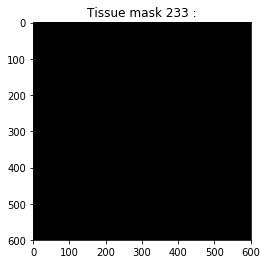

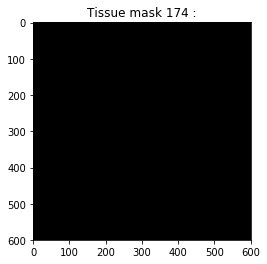

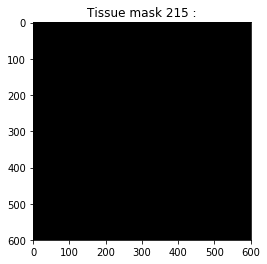

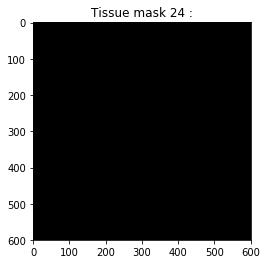

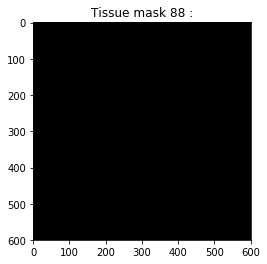

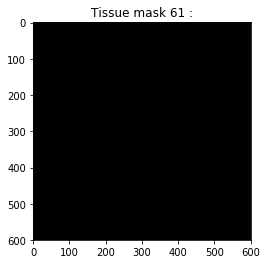

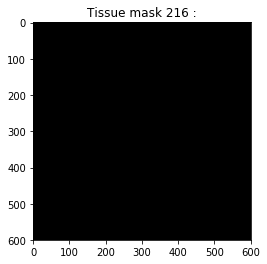

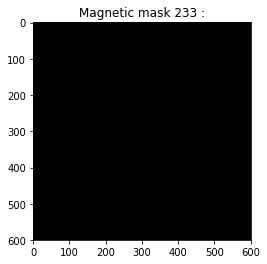

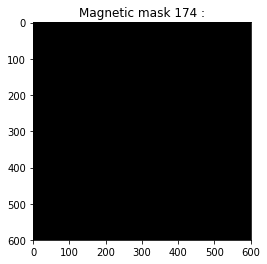

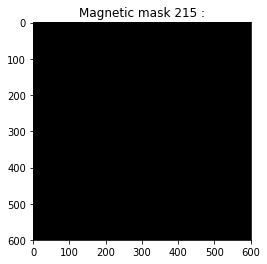

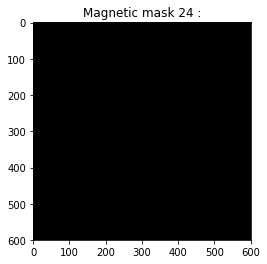

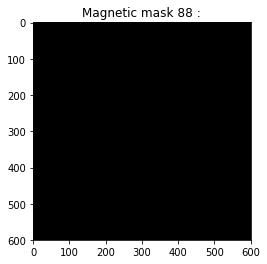

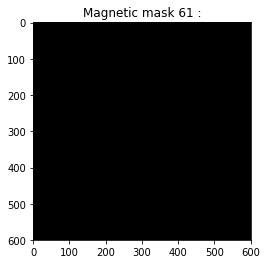

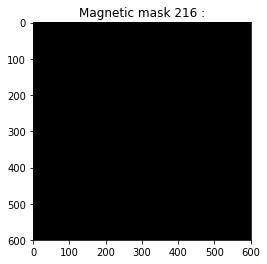

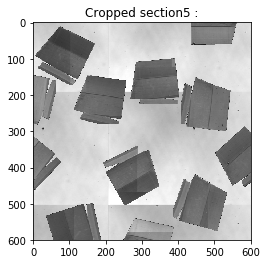

[68, 217, 265, 47, 281, 62]


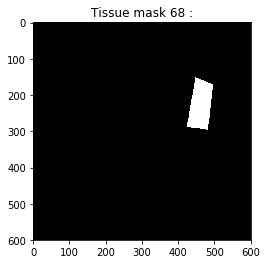

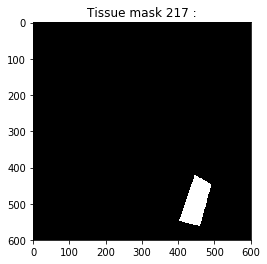

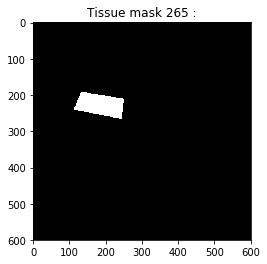

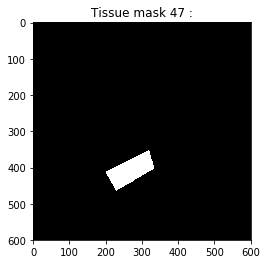

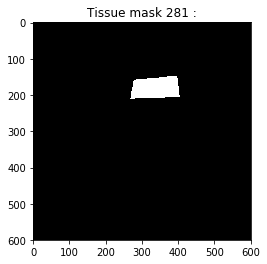

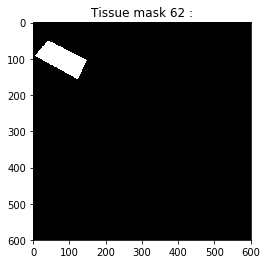

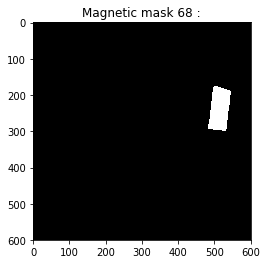

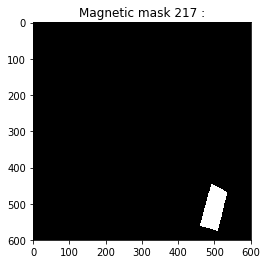

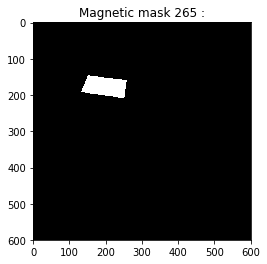

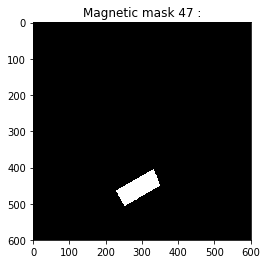

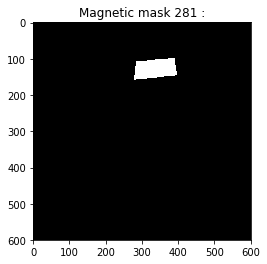

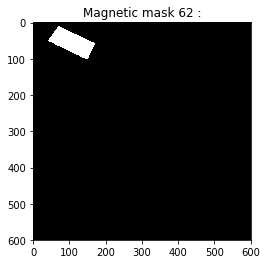

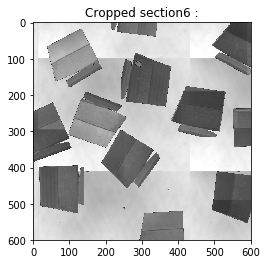

[65, 129, 136, 232, 138, 299]


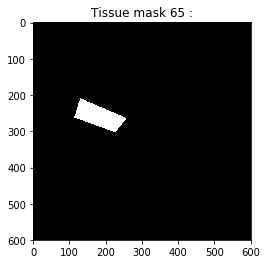

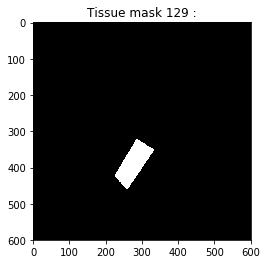

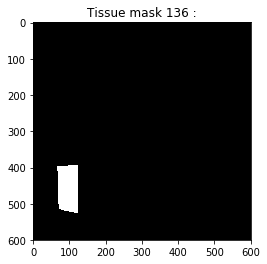

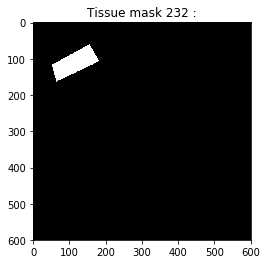

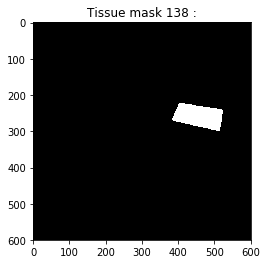

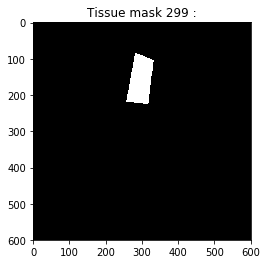

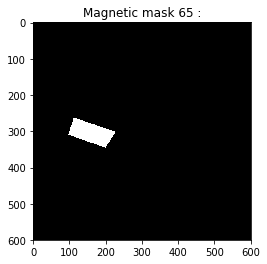

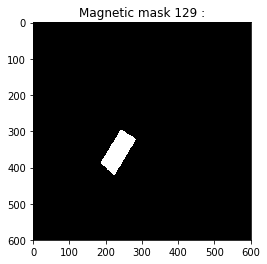

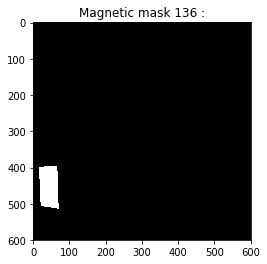

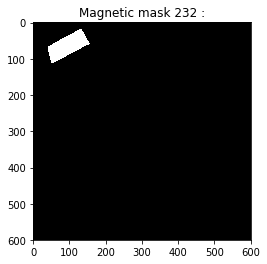

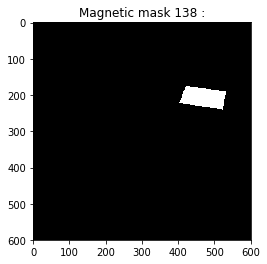

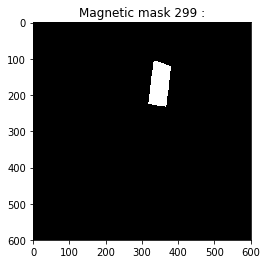

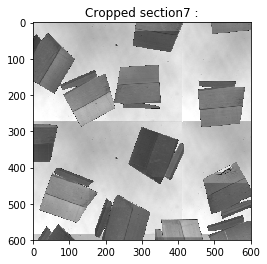

[4, 102, 105, 170, 179]


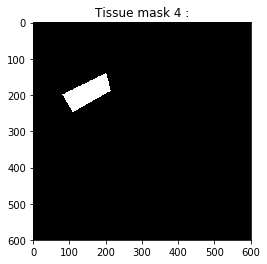

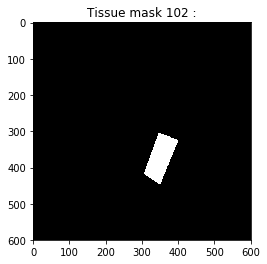

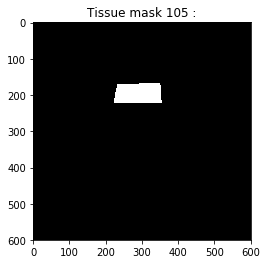

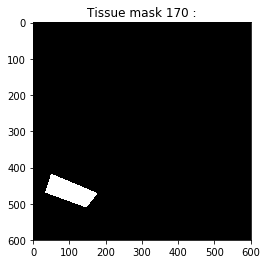

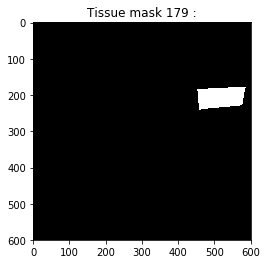

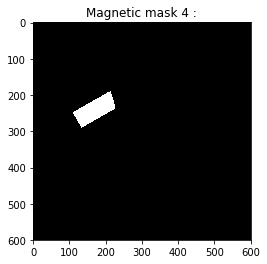

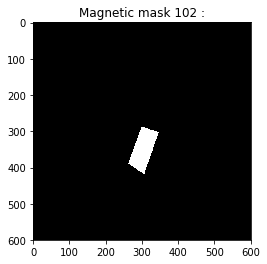

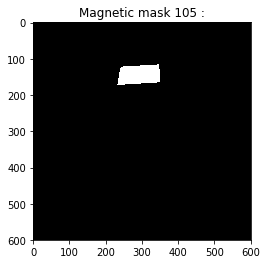

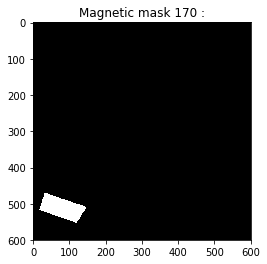

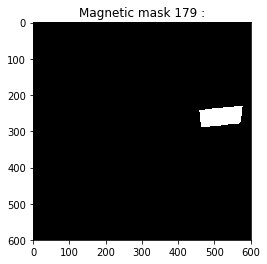

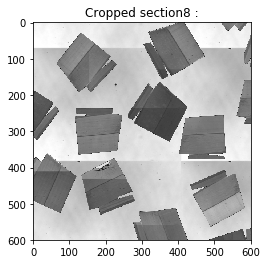

[5, 261, 229, 43, 247, 223]


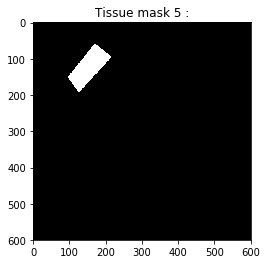

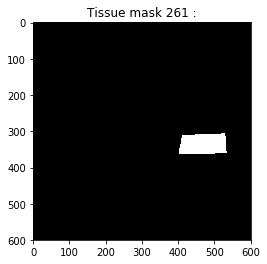

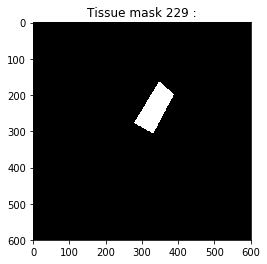

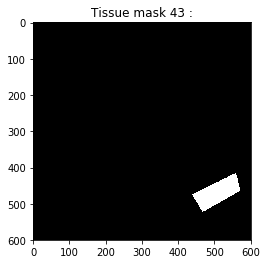

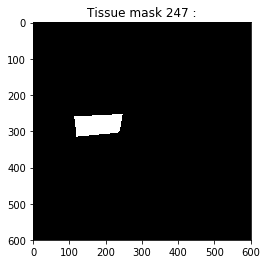

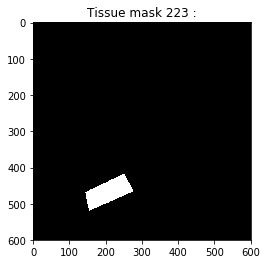

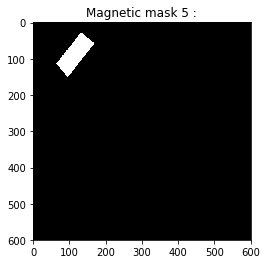

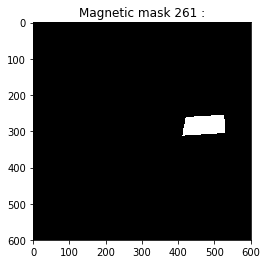

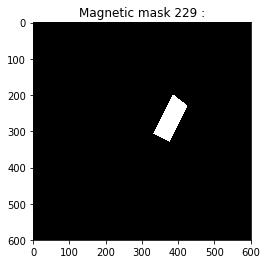

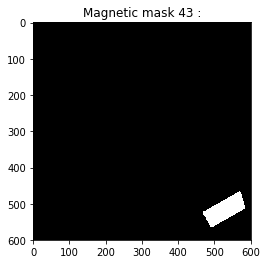

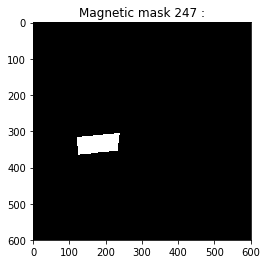

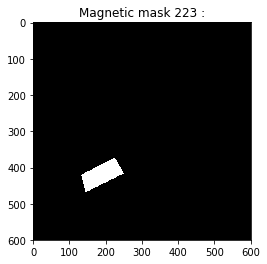

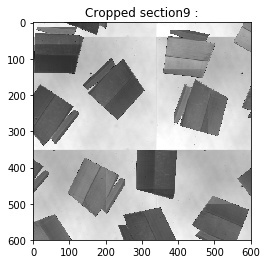

[194, 204, 77, 246, 187, 222]


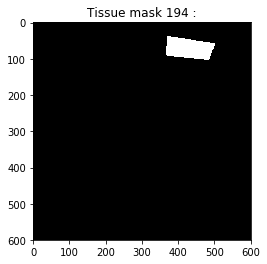

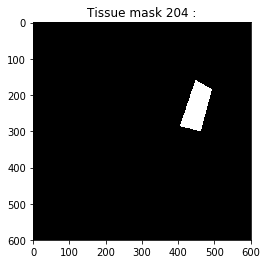

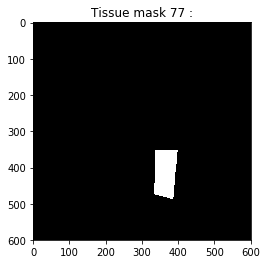

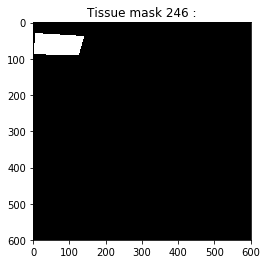

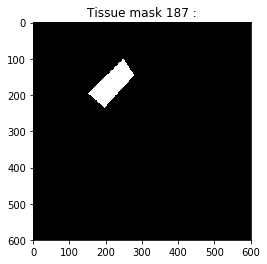

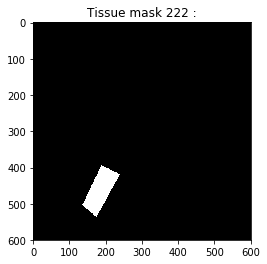

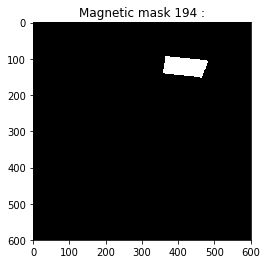

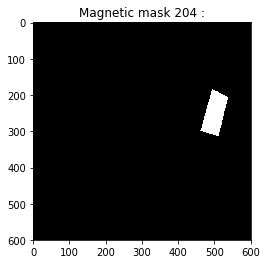

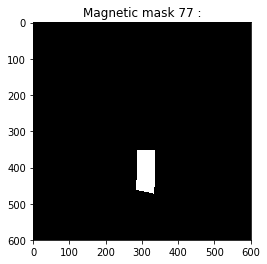

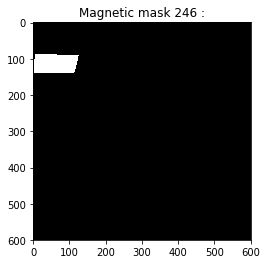

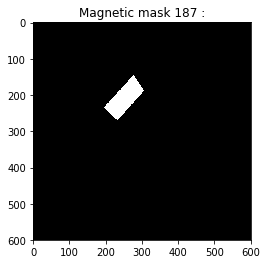

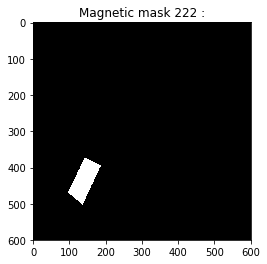

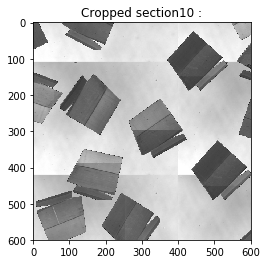

[163, 132, 11, 23, 220]


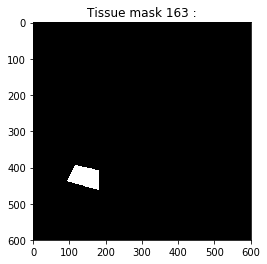

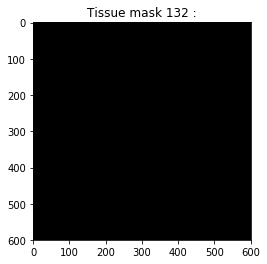

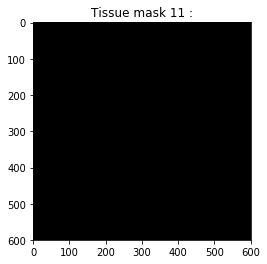

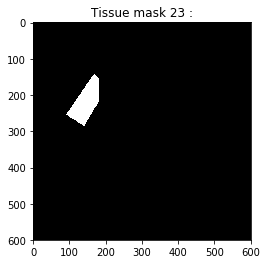

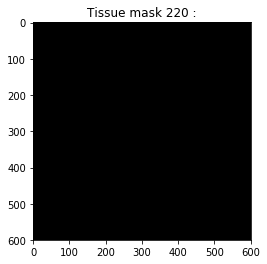

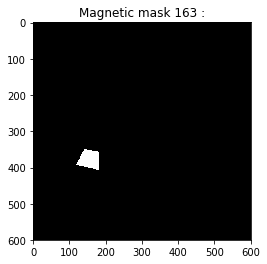

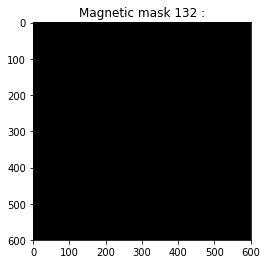

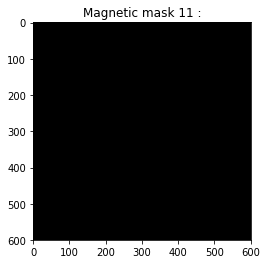

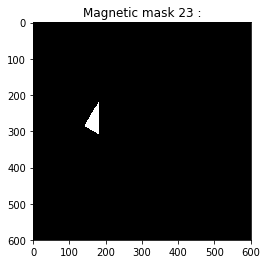

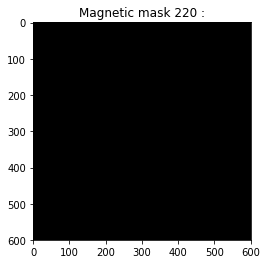

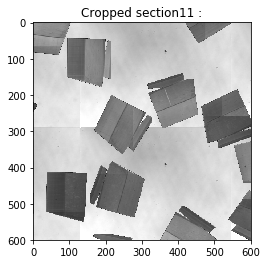

[0, 128, 270, 209, 19]


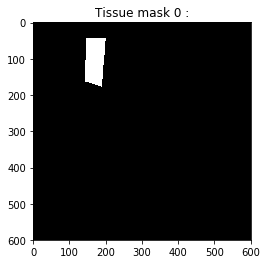

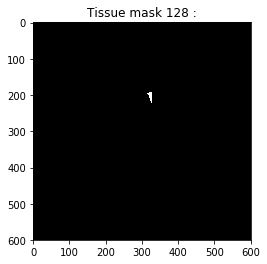

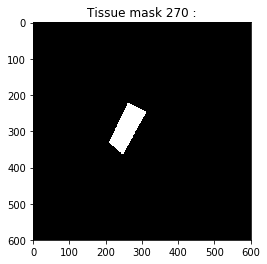

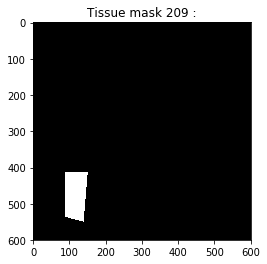

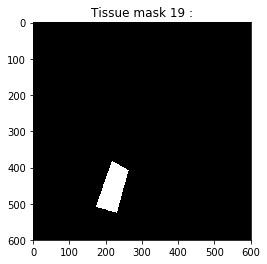

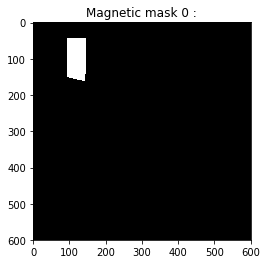

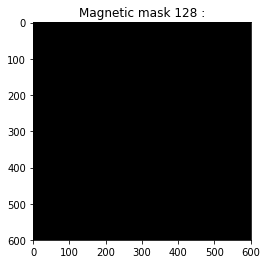

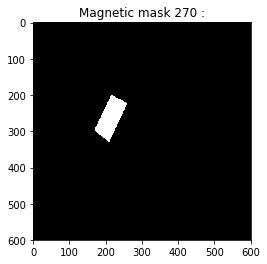

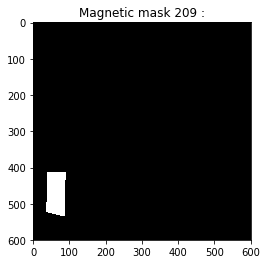

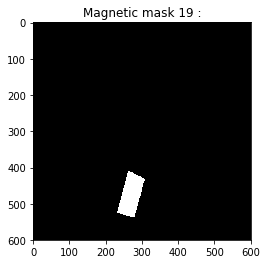

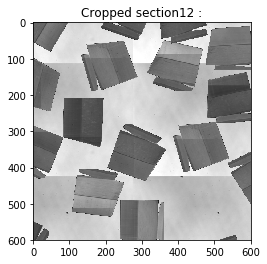

[100, 42, 235, 210, 51, 55]


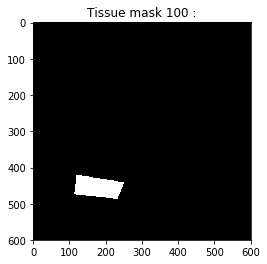

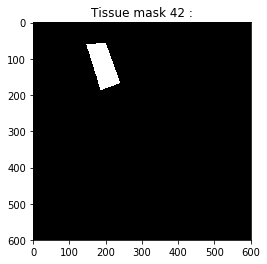

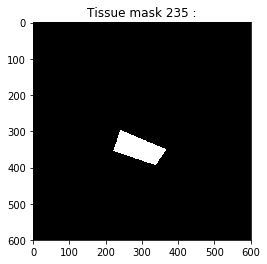

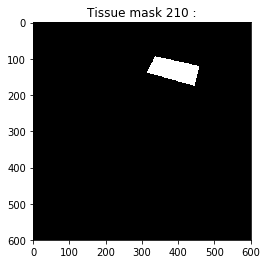

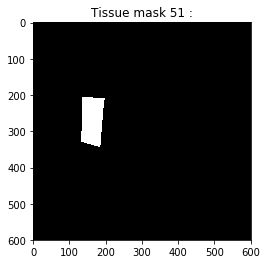

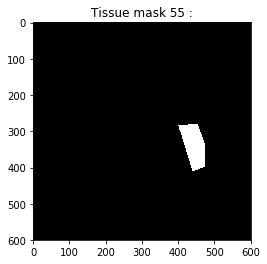

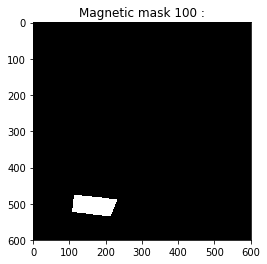

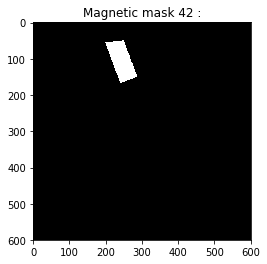

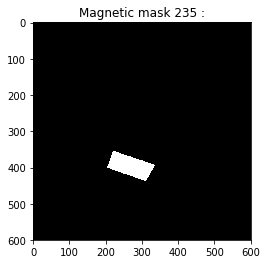

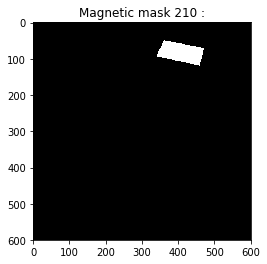

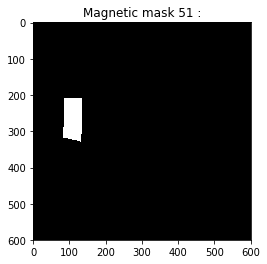

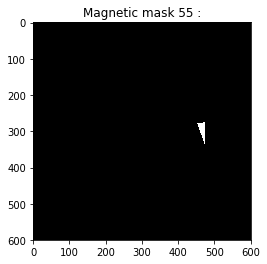

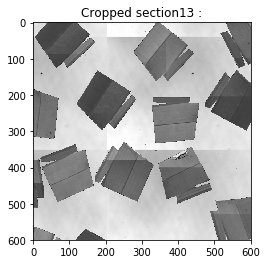

[64, 199, 12, 247, 223]


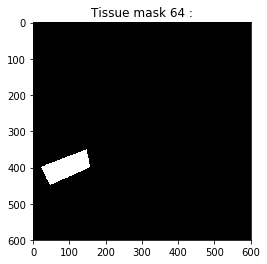

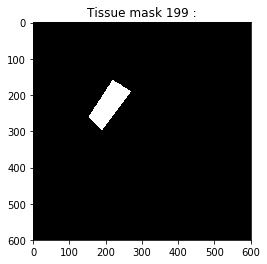

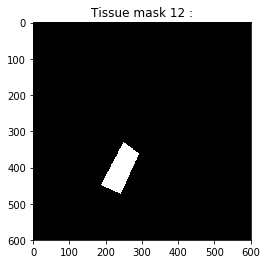

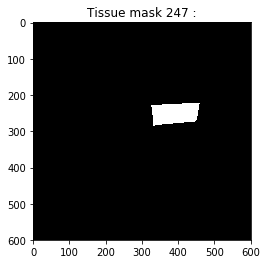

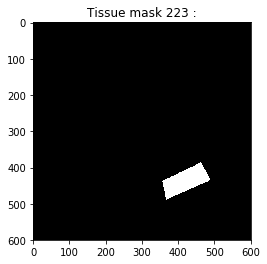

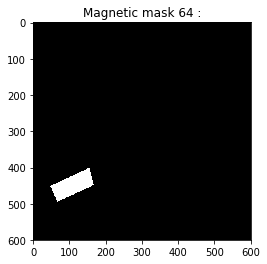

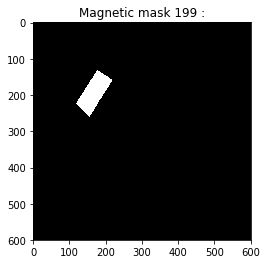

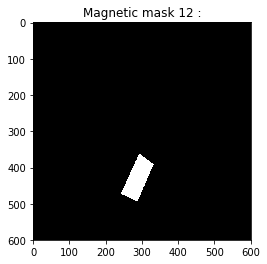

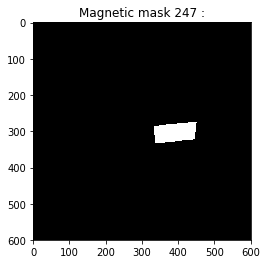

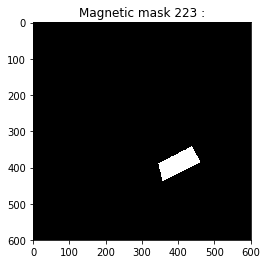

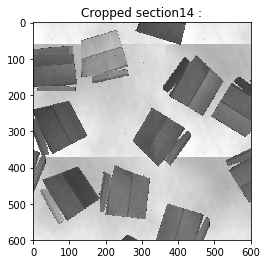

[134, 274, 87, 26, 91]


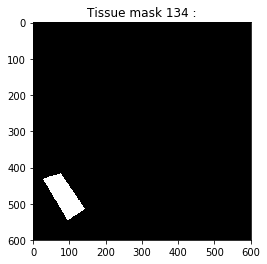

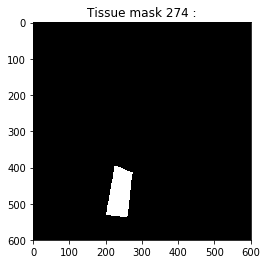

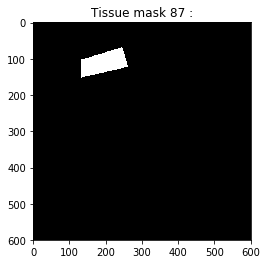

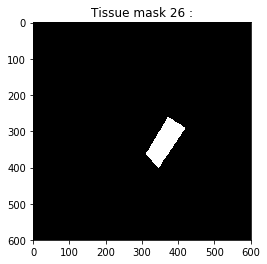

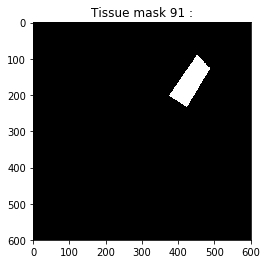

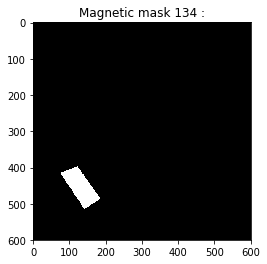

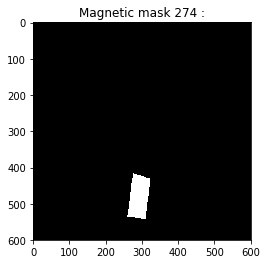

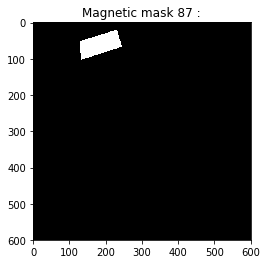

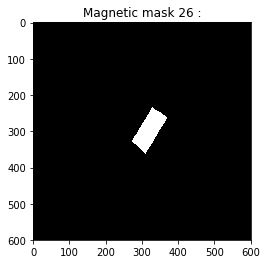

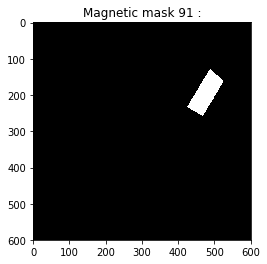

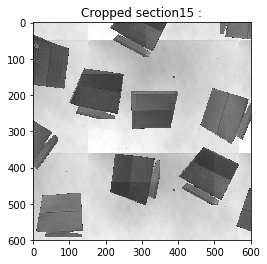

[224, 8, 138, 15, 243, 54]


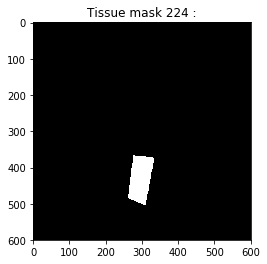

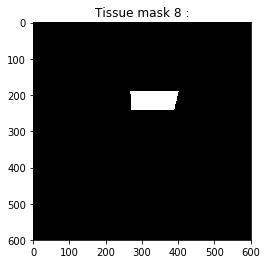

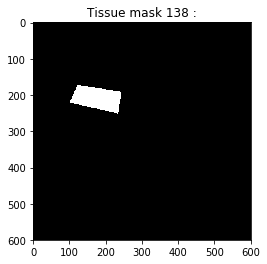

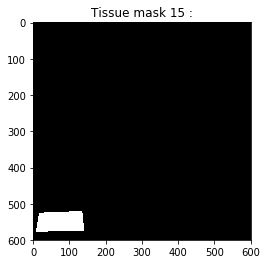

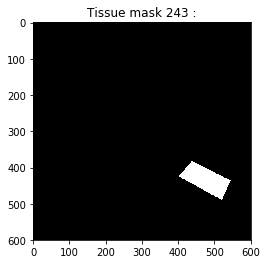

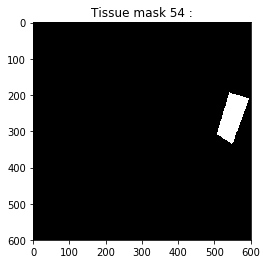

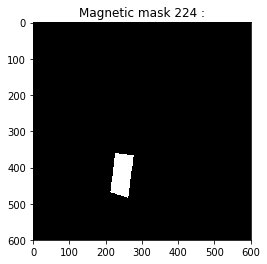

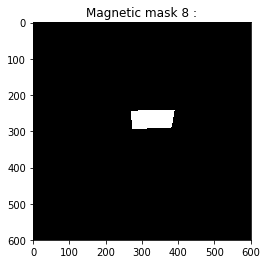

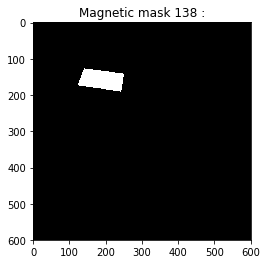

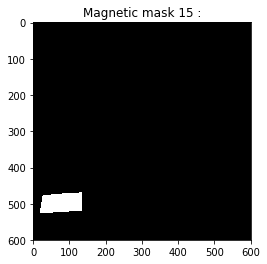

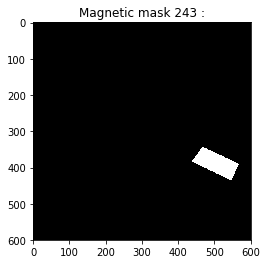

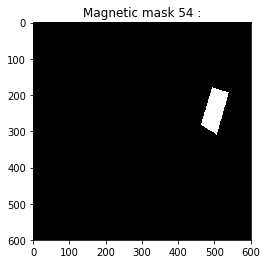

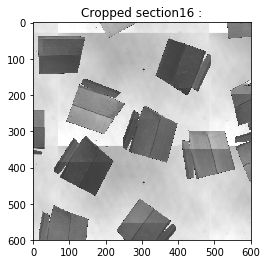

[99, 293, 102, 170, 206, 255]


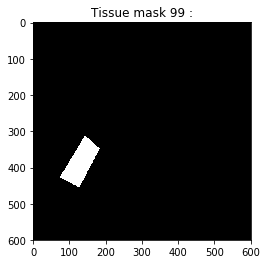

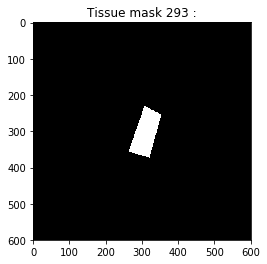

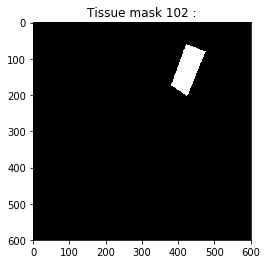

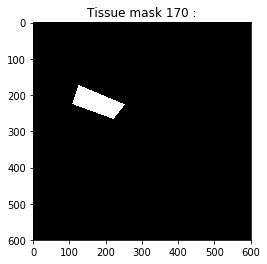

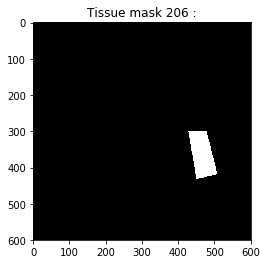

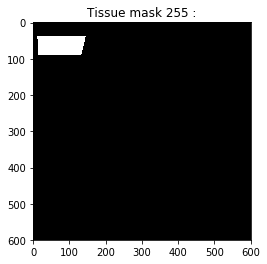

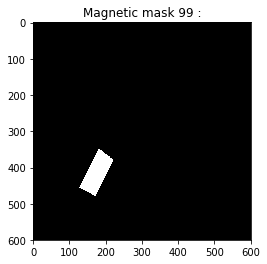

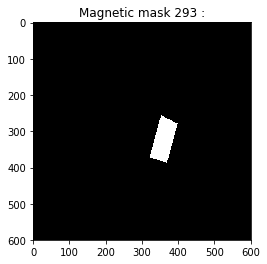

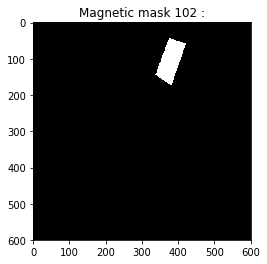

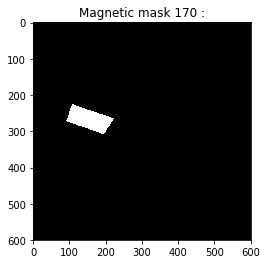

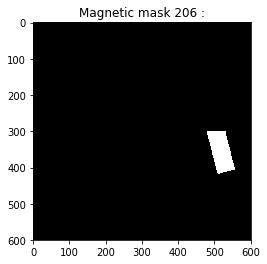

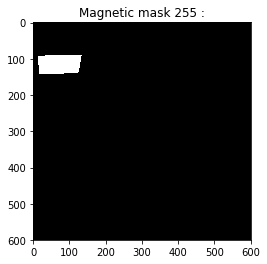

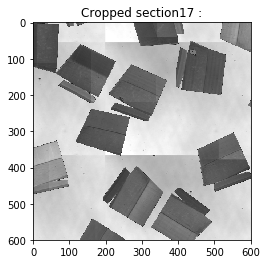

[197, 237, 272, 154, 91, 158]


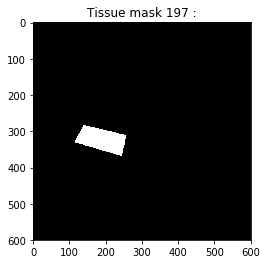

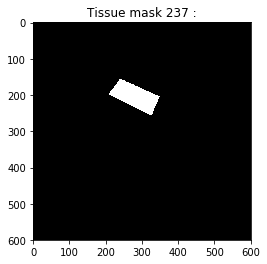

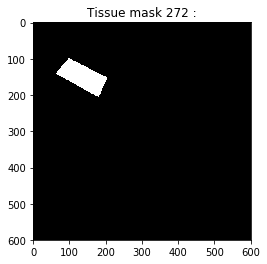

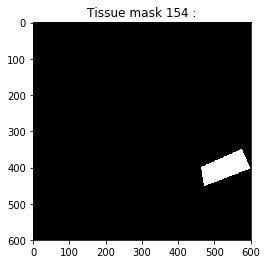

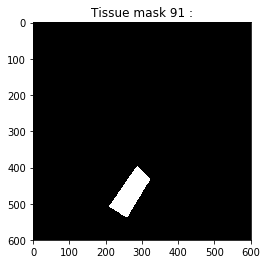

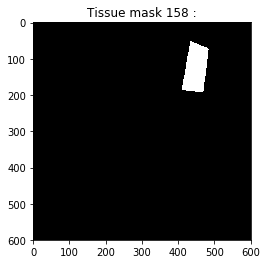

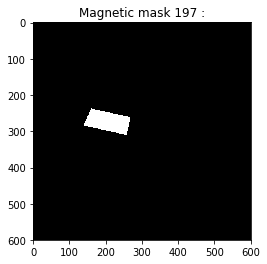

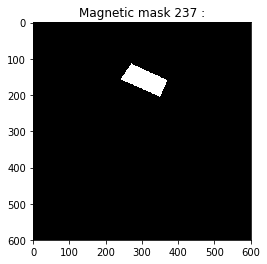

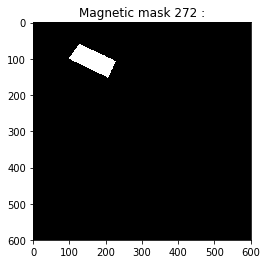

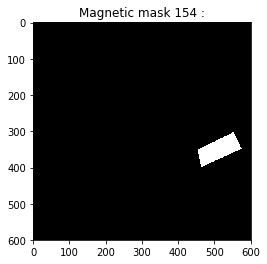

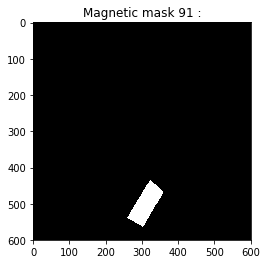

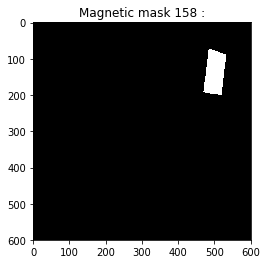

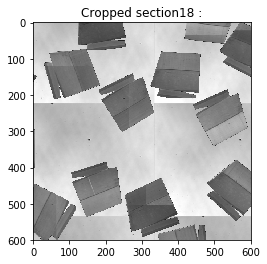

[128, 74, 143, 181, 55, 218]


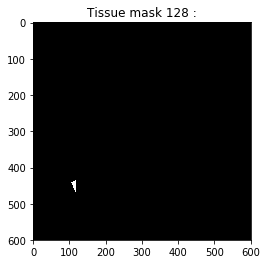

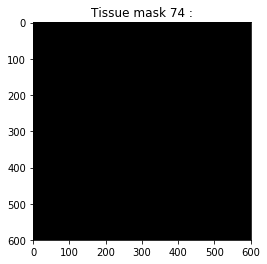

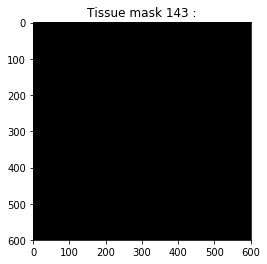

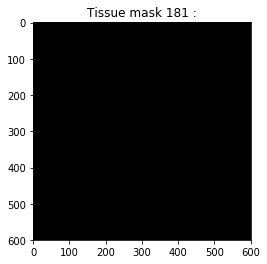

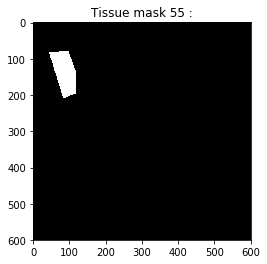

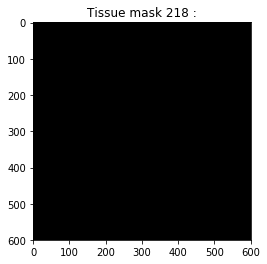

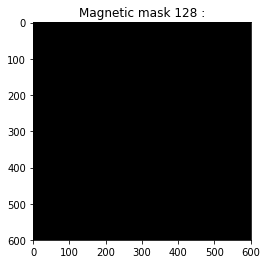

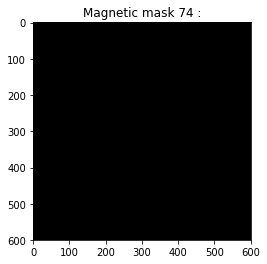

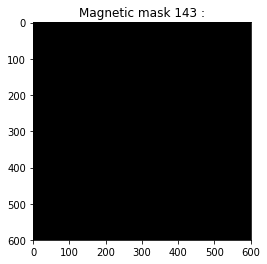

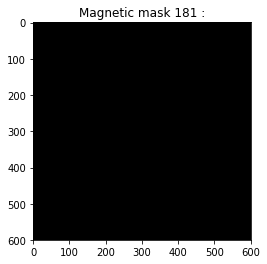

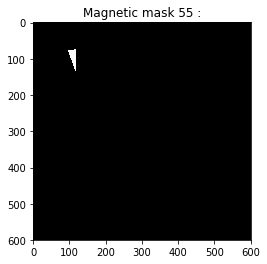

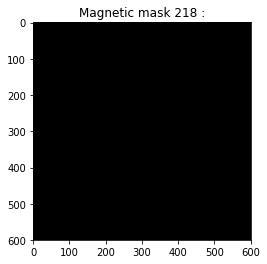

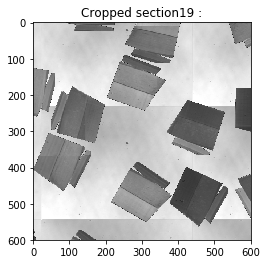

[259, 196, 40, 9, 16, 57]


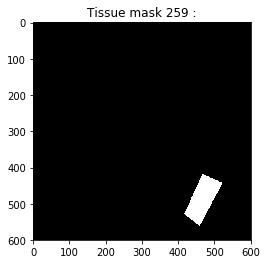

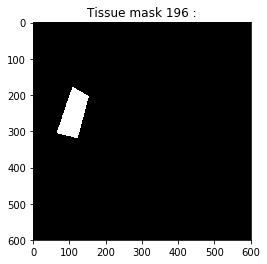

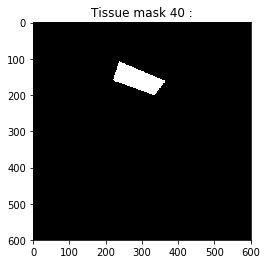

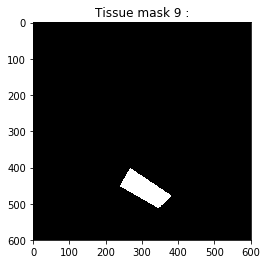

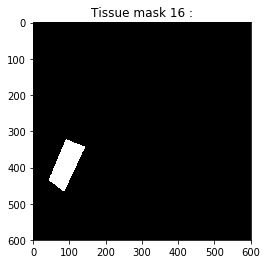

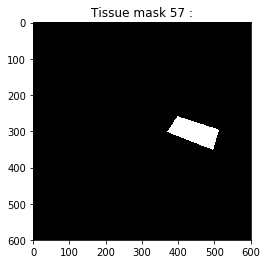

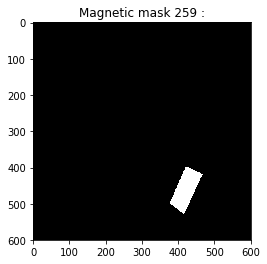

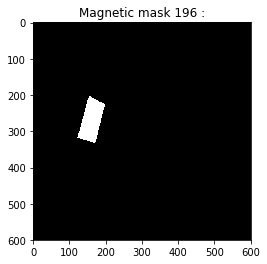

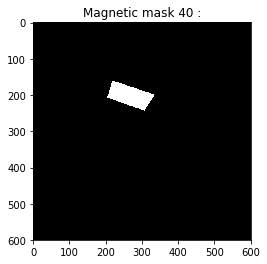

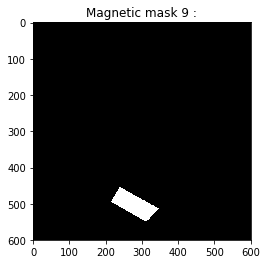

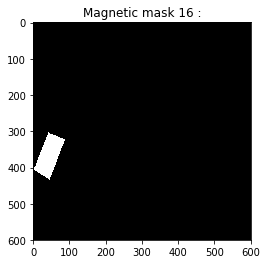

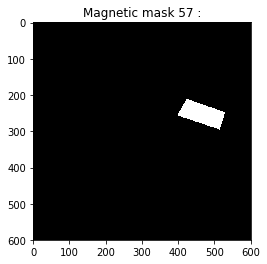

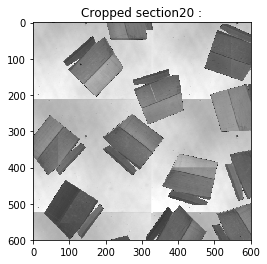

[166, 39, 10, 21, 188]


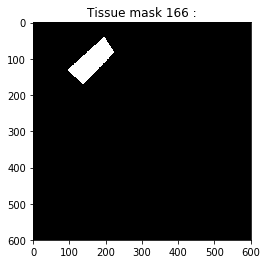

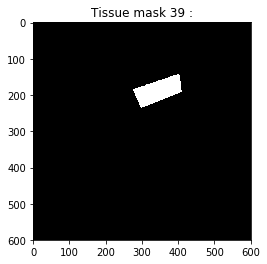

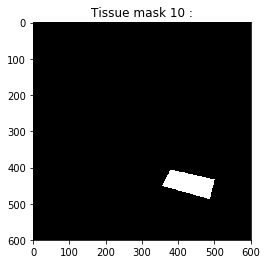

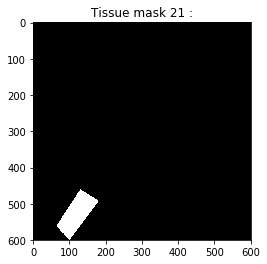

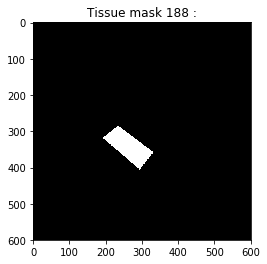

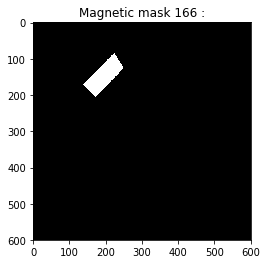

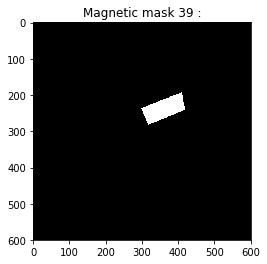

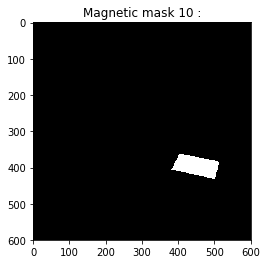

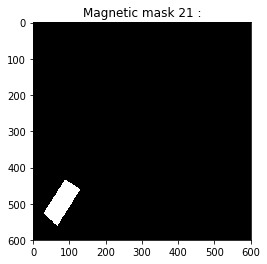

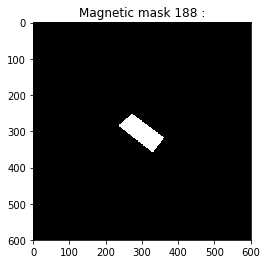

In [8]:
for i in range(1,number_of_sections+1):
    
    # random crop coordinates (top-left point of the cropped area)
    start_x = random.randint(0, wafer.size[0] - section_size)
    start_y = random.randint(0, wafer.size[1] - section_size)
    
    # creating directories to store results
    image_folder = "../augmented_dataset/stage1/crop"+str(i)+"/image/" 
    os.makedirs(os.path.dirname(image_folder), exist_ok=True)
    tissue_masks_folder = "../augmented_dataset/stage1/crop"+str(i)+"/tissue_masks/" 
    os.makedirs(os.path.dirname(tissue_masks_folder), exist_ok=True)
    magnetic_masks_folder = "../augmented_dataset/stage1/crop"+str(i)+"/magnetic_masks/" 
    os.makedirs(os.path.dirname(magnetic_masks_folder), exist_ok=True)
    
    # cropping the wafer image
    cropped_image = wafer.crop((start_x,start_y,start_x+section_size,start_y+section_size))
    plt.imshow(cropped_image)
    plt.title("Cropped section"+str(i)+" :")
    plt.show()  
        
    # saving the cropped image
    cropped_image.save(image_folder+str(i)+".tif")
    
    # index of all tissue part within the cropped area
    tissue_indicies = list()
    for index, row in seg_tissues.iterrows(): # iterating over sections
        points_within = 0
        for j in range(0,8,2): # iterating over the 4 points for each section
            if (start_x <= row[j] <= start_x+section_size) & (start_y <= row[j+1] <= start_y+section_size):
                points_within += 1
        if(points_within == 4):
            tissue_indicies.append(index)
    
    # index of all magnetic part within the cropped area
    mag_indicies = list()
    for index, row in seg_mag.iterrows(): # iterating over sections
        points_within = 0
        for j in range(0,8,2): # iterating over the 4 points for each section
            if (start_x <= row[j] <= start_x+section_size) & (start_y <= row[j+1] <= start_y+section_size):
                points_within += 1
        if(points_within == 4):
            mag_indicies.append(index)

    # keeping only sections indices if both part are within the cropped area
    section_indices = list( set(tissue_indicies) & set(mag_indicies) )
    print (section_indices)
    
    # creating tissue part mask
    for section_index in section_indices:
        vertices = np.array(seg_tissues.loc[[section_index]]).reshape((4, 2))
        #print(vertices)
        
        mask = generate_mask(wafer,vertices)
        
        _mask = Image.fromarray(np.uint8(mask))
        _mask = _mask.crop((start_x,start_y,start_x+section_size,start_y+section_size))
        #plt.imshow(_mask)
        #plt.title("Tissue mask "+str(section_index)+" :")
        #plt.show()  
        
        # saving the cropped mask
        _mask.save(tissue_masks_folder+str(section_index)+".tif")
    
    
    # creating magnetic part mask
    for section_index in section_indices:
        vertices = np.array(seg_mag.loc[[section_index]], 'int32').reshape((4, 2))
        #print(vertices)
        mask = generate_mask(wafer,vertices)
        _mask = Image.fromarray(np.uint8(mask))
        _mask = _mask.crop((start_x,start_y,start_x+section_size,start_y+section_size))

        #plt.imshow(_mask)
        #plt.title("Magnetic mask "+str(section_index)+" :")
        #plt.show()
        
        # saving the cropped mask
        _mask.save(magnetic_masks_folder+str(section_index)+".tif")
    